# Auxiliary modules

In [44]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
rc('font',**{'family':'monospace','monospace':['Courier']})
rc('text', usetex=True)
from pylab import *

import time
import numpy as np
import itertools
import copy

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
%autosave 180


def show_gallery(images, n_rows, n_cols=10):
    '''Show photos from set
    
    Args:
        images[k,m,n]: set of k images m*n
        n_rows (int): rows to show
        n_cols (int): columns to show in each row
    '''
    images = array(images)
    n_imgs = shape(images)[0]
    n_rows = min(n_rows, int(ceil(n_imgs/n_cols)))
    grid_size = (n_rows, n_cols)
    figure(figsize=reversed(grid_size))
    
    for i,j in itertools.product(range(n_rows), range(n_cols)):
        subplot2grid(grid_size, (i, j), colspan=1, rowspan=1, aspect="auto")
        if i*n_cols+j<n_imgs:
            imshow(images[i*n_cols+j], cmap='gray', interpolation="nearest")
        xticks(())
        yticks(())
        axis("off")
        grid(False)
        
    subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    show()
    
'''HOSVD'''
# https://en.wikipedia.org/wiki/Higher-order_singular_value_decomposition

def kmul(a,b,k):
    '''Mode-k multiplication (tensor-matrix multiplication)
        rank(a) = I1 x...x Ik-1 x Ik x Ik+1 x...x IN
        rank(b) = Ik x J
        rank(a x_k b) = I1 x...x Ik-1 x J x Ik+1 x...x IN'''
    # https://en.wikipedia.org/wiki/Tensor-matrix_multiplication
    rank = list(shape(a))
    rank[k] = len(b)
    c = unflat(b.dot(flat(a,k)),rank,k)
    return c
    
def gmul(a,B):
    '''Generalized (tensor-matrix) multiplication
        (for the set of matrices B for each dimension of tensor a)'''
    c = a
    for k in range(len(B)):
        c = kmul(c,B[k],k)
    return c
    
def ind(N, rank):
    '''Number in the index'''
    # Например rank = [2,3,4], N = 15
    # Тогда ind(0) = [0,0,0], ind(1) = [0,0,1]
    # ind(2) = [0,0,2], ind(4) = [0,1,0]
    # ind(5) = [0,1,1], ind(11) = [0,2,3]
    # И в конце концов, ind(N) = [1,0,3]
    I = []
    n = N
    for i in rank[::-1]:
        I = [n%i] + I
        n = int(n/i)
    return tuple(I)

def flaxis(tensor, k):
    '''Make k-th axis first'''
    # i1,i2,...,ik-1,ik,ik+1,...,iN
    # ik,i1,i2,...,ik-1,ik+1,...,iN
    k = k%len(shape(tensor))
    if k:
        return moveaxis(tensor, list(range(k+1)), [i for i in range(1,k+1)] + [0])
    else:
        return tensor
    
def kaxis(tensor, k):
    '''Make first axis k-th'''
    # ik,i1,i2,...,ik-1,ik+1,...,iN
    # i1,i2,...,ik-1,ik,ik+1,...,iN
    k = k%len(shape(tensor))
    if k:
        return moveaxis(tensor, list(range(k+1)), [k]+[i for i in range(k)])
    else:
        return tensor
    
def flat(tensor, k):
    '''tensor flatten'''
    rank = shape(tensor)
    return reshape(ravel(flaxis(tensor,k)),(rank[k],int(np.prod(rank)/rank[k])))

def unflat(flat_tensor, rank, k):
    '''MAKE TENSOR STRUCTURED AGAIN!'''
    return kaxis(concatenate(flat_tensor).reshape(flaxis(zeros(rank),k).shape),k)

def hosvd(tensor):
    '''High-Ordered Singular Value Decomposition'''
    # A = S x1 U1 x2 U2 ... xN UN
    N = len(shape(tensor))
    # Тензор A ранга I1 x I2 x...x IN
    # Тензор-матрица для k-ого измерения A(k) = Ik x (I1*...*Ik-1*Ik+1*...*IN)
    A = [flat(tensor, k) for k in range(N)]
    # A(k) = Uk*Σk*Vk, сохраняем Uk
    U = [linalg.svd(A[k], full_matrices=False)[0] for k in range(N)]
    # Тензор-ядро S = A x1 U1^T x2 U2^T ... xN UN^T
    S = gmul(tensor, [transpose(u) for u in U])
    return (S,U)

def subarr(a,d):
    if len(list(d)) > 1:
        return array([subarr(b,d[1:]) for b in a[:d[0]]])
    else:
        return a[:d[0]]

def trunc(s, U, dim, su=False):
    s_trunced = subarr(s,dim)
    U_trunced = [U[k][:,:dim[k]] for k in range(len(dim))]
    if su:
        return gmul(s_trunced, U_trunced), s_trunced, U_trunced
    else:
        return gmul(s_trunced, U_trunced)

# Тензорирование выборки
def tensoring(faces, features):
    dim1 = [len(set(array(features)[:,i])) for i in range(shape(features)[1])]
    dim2 = list(shape(faces))[1:]
    tensor = zeros(dim1+dim2)
    
    for face,f in zip(faces, features):
        tensor[tuple(f)] = face
    return tensor
    

'''Principal Component Number Estimators'''
def broken_stick(s, par=1):
    eigs = s**2
    c = sum(eigs)
    e = eigs/c
    n = len(eigs)
    l = [sum([1/j for j in range(i+1,n+1)])/n for i in range(n)]
    k = 1
    for i in range(1, n):
        if e[i] < l[i]:
            k = i
            break
    return k

def eps_rank(s, eps=1):
    k = 1
    n = len(s)
    for i in range(1, n):
        if s[i] <= eps:
            k = i
            break
    return k

def kaiser(s, alpha=0.95):
    if alpha >= 1:
        return len(s)
    else:
        eigs = s**2
        c = sum(eigs)
        n = len(eigs)
        k = 0
        for i in range(1, n):
            k += 1
            if sum(eigs[:i]) > alpha*c:
                break
        return k
       
PCN = {
    'Brocken Stick': lambda s, a: broken_stick(s, a),
    'Epsilon Rank': lambda s, a: eps_rank(s, a),
    'Kaiser': lambda s, a: kaiser(s, a),
    'Manual': lambda s, a: a,
    'Full': lambda s, a: len(s)
}

'''Алгоритм усреднения фотографии по соседним в смысле признаков'''
import copy

def neighbors_mean(A, w, i):
    B = copy.deepcopy(A)
    if sum(w[i[0]]) == 0:
        means = [neighbors_mean(B, w, [j]+list(i)[1:]) for j in range(shape(w)[0]) if sum(w[j]) > 0]
        return sum(means, axis=0)/len(means)
    else:
        if len(i) == 1:
            return B[i[0]]
        else:
            return neighbors_mean(B[i[0]], w[i[0]], i[1:])

def fill_gaps(A, f0, f):
    in_B = zeros(shape(A)[:len(f0[0])])
    for ftr in f0:
        in_B[tuple(ftr)] = 1
    B = copy.deepcopy(A)
        
    for ftr in f:
        if in_B[tuple(ftr)] == 0:
            nmean = neighbors_mean(B, in_B, ftr)
            B[tuple(ftr)] = nmean
    return B

Autosaving every 180 seconds


# ORL dataset

In [2]:
data = fetch_olivetti_faces()
X = data.images
y = data.target

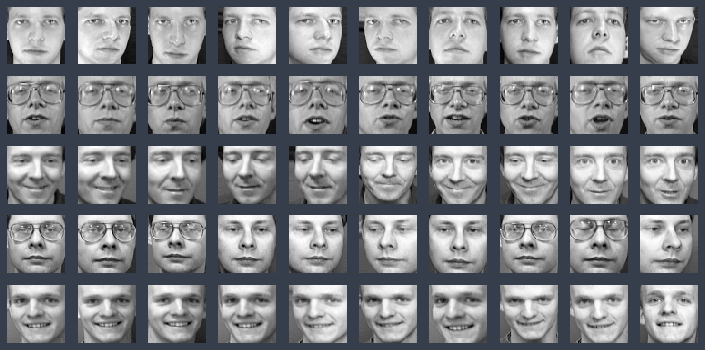

In [3]:
show_gallery(X, 5)

# HOSVD Experiments

#### Вычтем усреднение по всем координатам

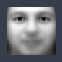

In [4]:
mean_face = average(X, axis=0)
show_gallery([mean_face], 1, 1)
F = X-mean_face

#### HOSVD-разложение

\begin{equation}A = S \times_{i=1}^N U_i\end{equation}

(400, 64, 64)
(400, 400)
(64, 64)
(64, 64)


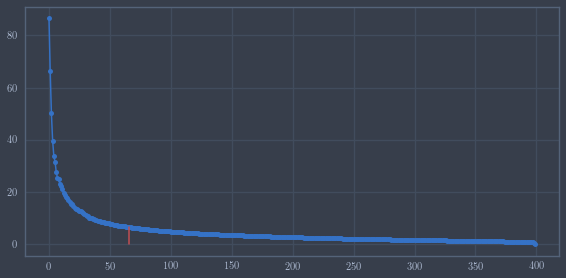

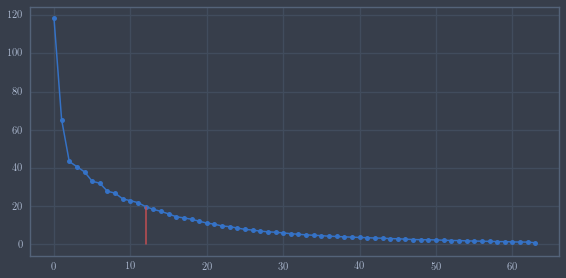

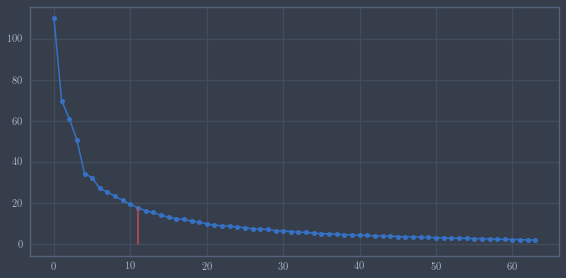

In [5]:
# Непосредственно разложение
N = len(shape(F))
A = [flat(F, k) for k in range(N)]
U = [linalg.svd(A[k], full_matrices=False)[0] for k in range(N)]
s = [linalg.svd(A[k], full_matrices=False)[1] for k in range(N)]
S = gmul(F, [transpose(u) for u in U])
# Ранги ядра и сингулярных матриц
print(shape(S))
for u in U:
    print(shape(u))
# Сингулярные значения развёрток
dim = []
for sigma in s:
    figure()
    k = PCN['Kaiser'](sigma, 0.9)
    dim += [k]
    
    plot(sigma, '-o', markersize=5)
    plot([k,k], [0,sigma[k]], 'r')
    show()

#### Аппроксимируем dim-ранговым подпространством

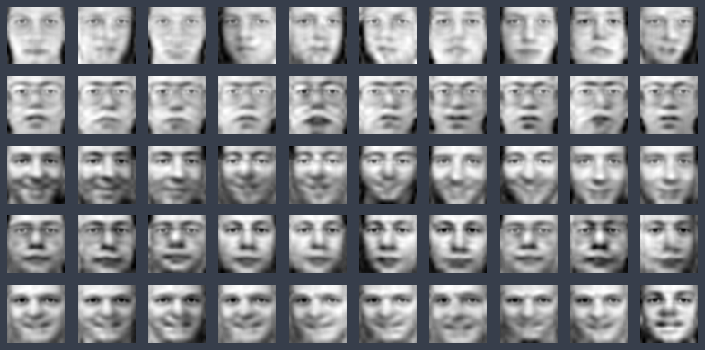

In [6]:
T, S1, U1 = trunc(S, U, dim, su=True)
show_gallery(T+mean_face, 5)

#### Спроецируем лица двумя способами
\begin{equation}p0 = T \times_1 U_1^T \times_2 U_2^T\end{equation}

\begin{equation}p1 = S \times_0 U_0\end{equation}

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

p0 = gmul(T, [eye(400), U1[1].T, U1[2].T])
p1 = kmul(S1, U1[0], 0)
print(shape(p0), shape(p1))

(400, 12, 11) (400, 12, 11)


#### Убедимся, что в результате получаются одинаковые проекции

In [8]:
k = np.random.choice(400,1)

print(p0[k,:3,:3])
print()
print(p1[k,:3,:3])
print()
print(norm(p0-p1))

[[[-9.76809513  0.09771789  1.31674155]
  [-0.19881025 -1.10154139  0.92665141]
  [ 1.71327796 -0.33878072  0.19268067]]]

[[[-9.76809502  0.09771787  1.31674159]
  [-0.19881023 -1.1015414   0.92665136]
  [ 1.71327794 -0.33878073  0.19268064]]]

7.02517614515e-06


In [9]:
clf = LogisticRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
score = average(cross_val_score(clf, [np.concatenate(p) for p in p0], y, cv=cv, scoring='accuracy'))
print(round(score,4)*100,'%')

96.38 %


In [10]:
clf = LogisticRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
score = average(cross_val_score(clf, [np.concatenate(p) for p in p1], y, cv=cv, scoring='accuracy'))
print(round(score,4)*100,'%')

96.38 %


### Тензор-ядро и сингулярные значения развёрток
Зададимся теперь вопросом: какова связь между сингулярными значениями развёрток и ядром тензора?
Рассмотрим оставленные сингулярные значения и оставленные элементы ядра:

In [11]:
s1 = [s[i][:dim[i]] for i in range(3)]
S1 = S[[slice(0,dim[i]) for i in range(3)]]

print(norm(s1[0]))
print(norm(s1[1]))
print(norm(s1[2]))
print(norm(S1))
# Совпадение?

168.579
168.724
168.957
160.619


In [12]:
print(norm(s[0]))
print(norm(s[1]))
print(norm(s[2]))
print(norm(S))
# Не думаю!

177.674
177.674
177.674
177.674


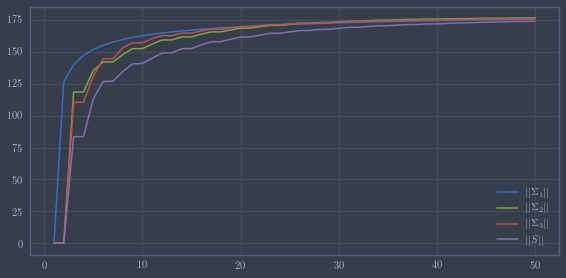

In [13]:
# Отобразим сей факт на графике
figure()
norms = []
max_per_cent = 50
for per_cent in range(max_per_cent):
    d = vectorize(int)((array((400,64,64))*per_cent/100.0))
    s1 = [s[i][:d[i]] for i in range(3)]
    S1 = S[[slice(0,d[i]) for i in range(3)]]
    norms += [[norm(s1[0]), norm(s1[1]), norm(s1[2]), norm(S1)]]
for n in array(norms).T:
    plot(range(1, max_per_cent+1), n)
rc('text', usetex=True)
rc('font', family='serif')
legend([r"$||{\Sigma_1}||$", r"$||{\Sigma_2}||$", r"$||{\Sigma_3}||$", r"$||{S}||$"])
show()

# Напомним, Σ1 соответствует фотографиям (выделяются типажи), полный ранг 400;
# Σ2 и Σ3 соответствуют строкам и столбцам, полные ранги – 64 и 64;
# S – ядро тензора всей выборки в совокупности.

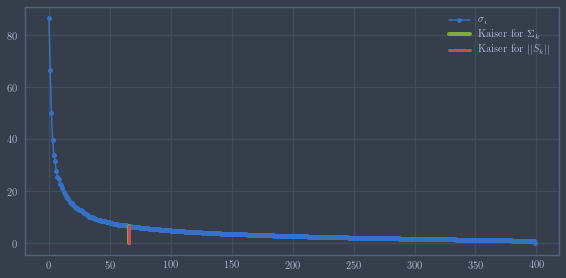

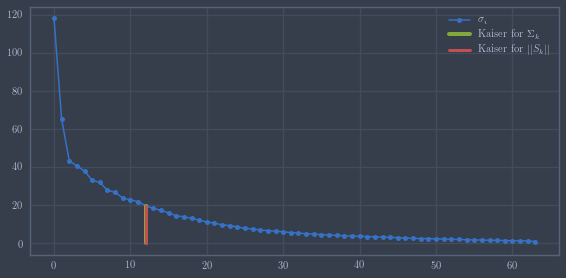

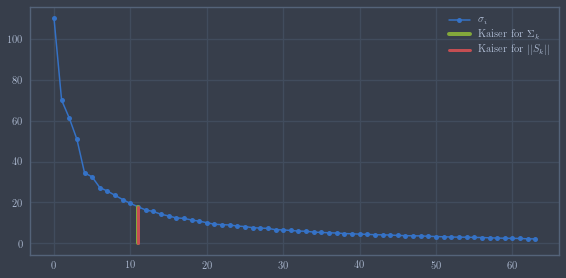

In [14]:
alpha = 0.9

rank = shape(S)
S_n1 = array([norm(S[d,:,:]) for d in range(rank[0])])
S_n2 = array([norm(S[:,d,:]) for d in range(rank[1])])
S_n3 = array([norm(S[:,:,d]) for d in range(rank[2])])
dim_n = [PCN['Kaiser'](S_n1, alpha),
         PCN['Kaiser'](S_n2, alpha),
         PCN['Kaiser'](S_n3, alpha)]

dim = []
for sigma in s:
    k = PCN['Kaiser'](sigma, alpha)
    dim += [k]

for i in range(3):
    figure()
    plot(s[i], '-o', markersize=5)
    plot([dim[i],dim[i]], [0, s[i][dim[i]]], 'g', linewidth=4)
    plot([dim_n[i],dim_n[i]], [0, s[i][dim_n[i]]], 'r', linewidth=3)
    legend([r'$\sigma_i$', r'Kaiser for $\Sigma_k$', r'Kaiser for $||S_k||$'])
show()

# Результат совпадает!

# Weizmann FaceBase dataset

In [15]:
import glob
import collections
from PIL import Image


file_names = []
for d in glob.glob('data/weizmann-facebase/*.png'): file_names += [d[23:-4]]
labels = []
for fn in file_names: labels += [fn.split('-')]
f = [sort(list(set([l[i] for l in labels]))) for i in range(4)]
features = []
for l in labels:
    features += [[np.where(f[i]==l[i])[0][0] for i in range(4)]]

size = 512,352
a = 0.35
X = []
for g in features:
    file_name = '%s-%s-%s-%s' % (f[0][g[0]], f[1][g[1]], f[2][g[2]], f[3][g[3]])
    img = Image.open('data/weizmann-facebase/' + file_name + '.png').convert('L')
    img.thumbnail([int(a*size[1]), int(a*size[0])], Image.ANTIALIAS)
    h, w = int(0.15*a*size[0]), int(0.12*a*size[1])
    X += [array(img)[2*h:-h,w:-w]]
    
X = array(X)
print(shape(X))

(1260, 100, 95)


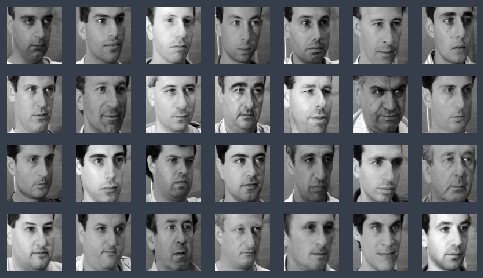

In [16]:
r = np.random.choice(45, 1)[0]
subset = array([X[i] for i in range(1260) if i%45==r])
show_gallery(subset, 4, 7)

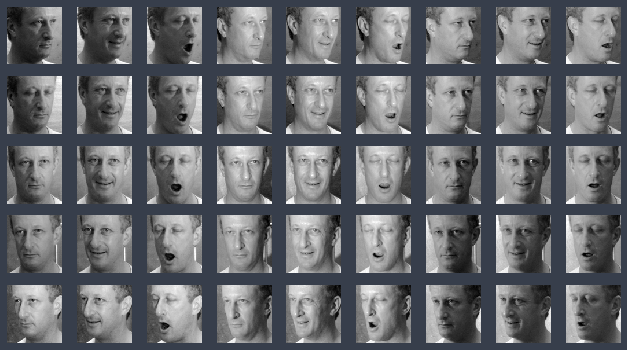

In [17]:
k = np.random.choice(28, 1)[0]
subset = array([X[i] for i in range(1260) if features[i][0]==k])
show_gallery(subset, 5, 9)

# Cold Start

#### Как бороться с пропусками?
Подчеркнём, что нам важно не реконструировать с большой точностью отсутствующие фотографии, а всего-навсего заполнить их похожими лицами, чтобы они не вносили существенного веса при разложении.

Попытка №1. Попробуем заполнить пропуски усреднённым лицом: 

\begin{equation}x_{ijkl} = E[x],\ x \in X_{train}\end{equation}

(28, 5, 3, 3, 100, 95)
11970000


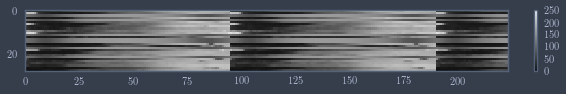

(28, 427500) people


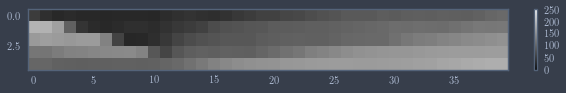

(5, 2394000) pose variations


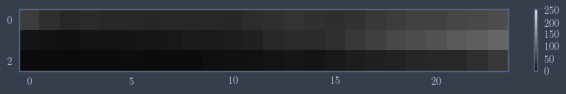

(3, 3990000) illuminations


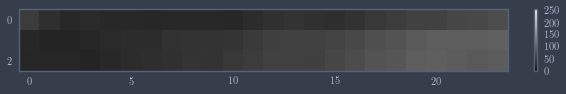

(3, 3990000) expressions


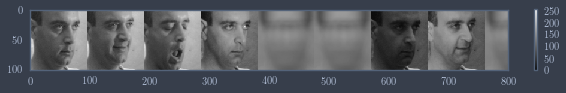

(100, 119700) rows


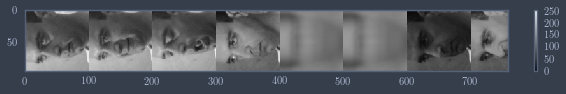

(95, 126000) columns


In [18]:
import yt

X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))
mean0 = sum(X0, axis=0)/len(X0)
T0 = tensoring(X0-mean0, features0)
print(shape(T0))
n_pix = product(shape(T0))
print(n_pix) # около 12 млн. значений хранится в исходном тензоре!

flattens0 = array([flat(T0+mean0,k) for k in range(len(shape(T0)))])

for flatten,name in zip(flattens0,['people', 'pose variations', 
                                  'illuminations', 'expressions', 
                                  'rows', 'columns']):
    figure()
    imshow(flatten[:,:8*len(flatten)], cmap=get_cmap('gray')).set_clim(vmin=0, vmax=255)
    grid(False)
    colorbar(fraction=0.006, pad=0.05)
    show()
    print(shape(flatten),name)

In [19]:
S0,U0 = hosvd(T0)

In [20]:
alpha = 0.95
Sn = [array([norm(flaxis(S0,i)[j]) for j in range(shape(S0)[i])]) for i in range(len(shape(S0)))]
dim = [PCN['Kaiser'](sn, alpha) for sn in Sn]
print(dim)

T0tr, S0tr, U0tr = trunc(S0, U0, dim, su=True)

[23, 4, 2, 2, 12, 14]


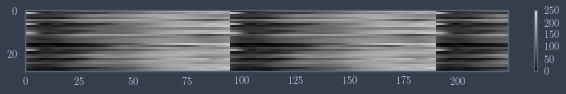

(28, 427500) people


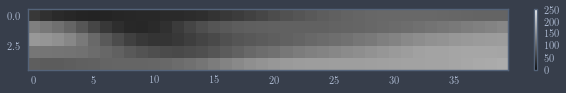

(5, 2394000) pose variations


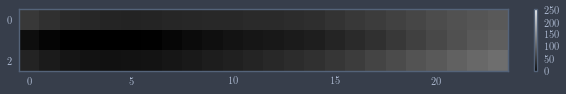

(3, 3990000) illuminations


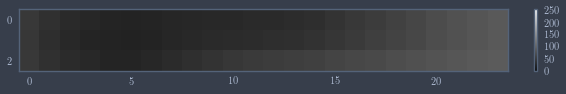

(3, 3990000) expressions


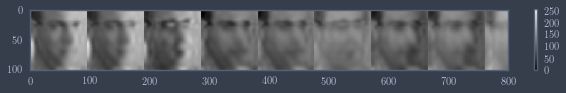

(100, 119700) rows


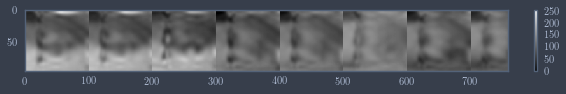

(95, 126000) columns


In [21]:
flattens = array([flat(T0tr+mean0,k) for k in range(len(shape(T0tr)))])

for flatten,name in zip(flattens,['people', 'pose variations', 
                                  'illuminations', 'expressions', 
                                  'rows', 'columns']):
    figure()
    imshow(flatten[:,:8*len(flatten)], cmap=get_cmap('gray')).set_clim(vmin=0, vmax=255)
    grid(False)
    colorbar(fraction=0.006, pad=0.05)
    show()
    print(shape(flatten),name)

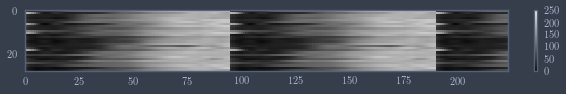

(28, 427500) people


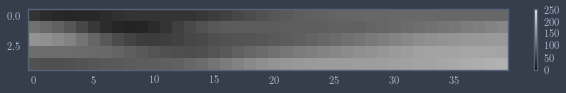

(5, 2394000) pose variations


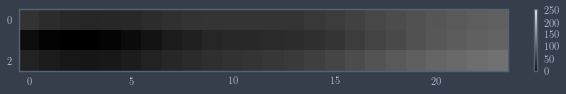

(3, 3990000) illuminations


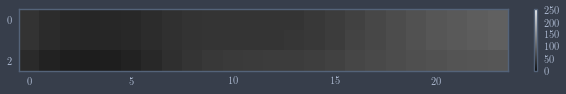

(3, 3990000) expressions


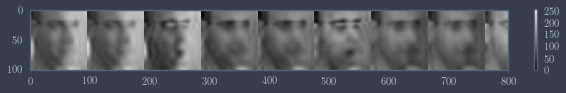

(100, 119700) rows


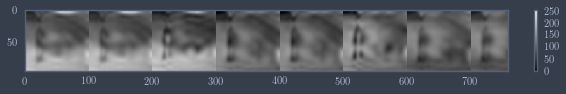

(95, 126000) columns


In [22]:
mean = sum(X, axis=0)/len(X)
T = tensoring(X-mean, features)
S,U = hosvd(T)
Ttr, Str, Utr = trunc(S, U, dim, su=True)

flattens = array([flat(Ttr+mean,k) for k in range(len(shape(Ttr)))])
for flatten,name in zip(flattens,['people', 'pose variations', 
                                  'illuminations', 'expressions', 
                                  'rows', 'columns']):
    figure()
    imshow(flatten[:,:8*len(flatten)], cmap=get_cmap('gray')).set_clim(vmin=0, vmax=255)
    grid(False)
    colorbar(fraction=0.006, pad=0.05)
    show()
    print(shape(flatten),name)

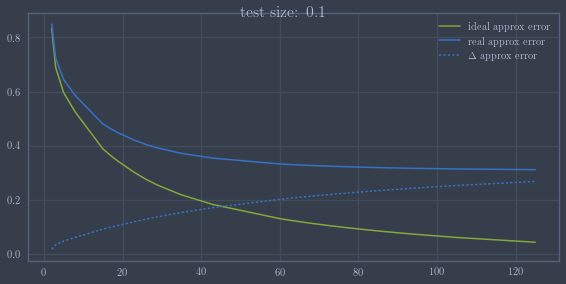

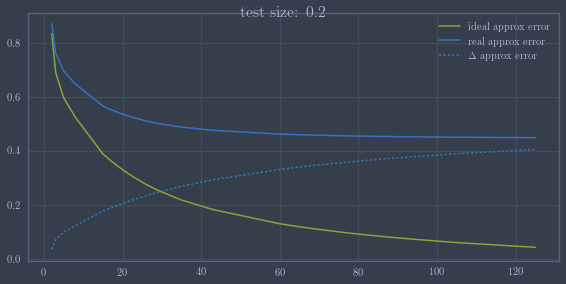

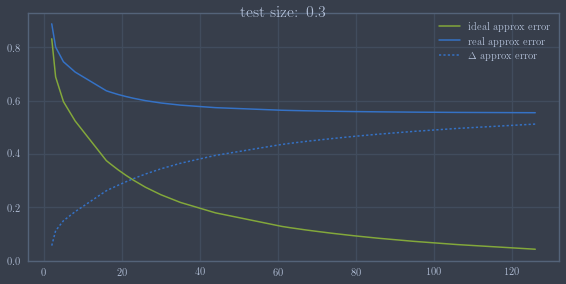

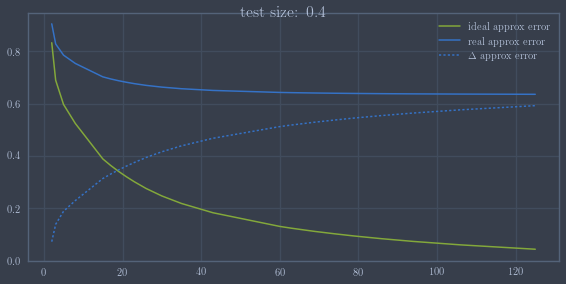

In [23]:
level = 3
points = [0]
for l in array(range(level))+1:
    start = points[-1]
    points += [start+i/10**l for i in range(1,10)]

for test_size in [.1, .2, .3, .4]:
    X0, X1, features0, features1 = train_test_split(X, features, test_size=test_size, 
                                                random_state=int(np.random.random()*1260))
    mean0 = sum(X0, axis=0)/len(X0)
    T0 = tensoring(X0-mean0, features0)
    S0,U0 = hosvd(T0)
    
    error0 = []
    error1 = []
    error2 = []
    n_comp = []
    
    Sn = [array([norm(flaxis(S0,i)[j]) for j in range(shape(S0)[i])]) for i in range(len(shape(S0)))]
    for alpha in points:
        dim = [28,5,3,3]+[PCN['Kaiser'](sn, alpha) for sn in Sn[-2:]]
        n_comp += [sum(dim[-2:])]
    
        T0tr = trunc(S0, U0, dim)
        Ttr = trunc(S, U, dim)
        error1 += [norm(T-Ttr)/norm(T)]
        error2 += [norm(T-T0tr)/norm(T)]
        error0 += [error2[-1]-error1[-1]]
        
    figure()
    suptitle('test size: ' + str(test_size), fontsize=16)
    plot(n_comp, error1, label=r'ideal approx error', color='g')
    plot(n_comp, error2, label=r'real approx error', color='b')
    plot(n_comp, error0, ':', label=r'$\Delta$ approx error', color='b')
    legend()
    show()

In [24]:
Sn = [array([norm(flaxis(S,i)[j]) for j in range(shape(S)[i])]) for i in range(len(shape(S)))]
dim = [PCN['Kaiser'](sn, 0.91) for sn in Sn]
print(sum(dim))

40


In [25]:
print([PCN['Kaiser'](sn, 0.98) for sn in Sn]) 
# Ранг тензора в таком случае таков:

[24, 4, 2, 2, 20, 23]


• Обозначим $A$ как набор всех имеющихся объектов.

• Обозначим $A_{i_1,i_2,...,i_p}$ как объект этого набора.

• Обозначим $A_{i_1,...i_{k-1},*,i_{k+1},...,i_p}$ как подмножество объектов набора, где все кроме k-го индекса имеют заданные значения. Та же запись сокращённо: $A_{i_1,...i_{k-1}}$. 

• Если в подмножестве $A_{i_1,...i_{k-1}}$ единственный элемент, обозначим его также.

#### Алгоритм:

$f(A, i_1,i_2,...,i_p)$
1. Если $\ A_{i_1} = \emptyset$, возвращаем E$[\ f(A_j, {i_2,...,i_p})]$

2. Если $\ |\ A_{i_1}| = 1$, возвращаем $ A_{i_1}$

2. Если $\ |\ A_{i_1}| > 1$, возвращаем $ f(A_{i_1}, {i_2,...,i_p})$


In [27]:
X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))
mean0 = sum(X0, axis=0)/len(X0)
T0 = tensoring(X0-mean0, features0)
Tnm = tensoring(X0-mean0, features0)
Tnm = fill_gaps(Tnm, features0, features) # Описанный выше алгоритм
print(shape(Tnm))

(28, 5, 3, 3, 100, 95)


Исходные фотографии:


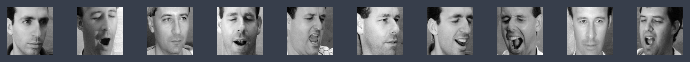

Соседние средние:


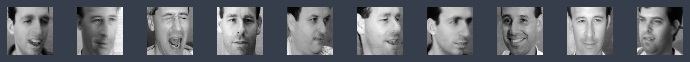

Средние (попытка №1):


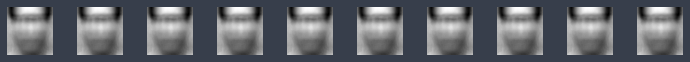

In [28]:
gaps = []
for ftr in array(features1)[choice(len(features1),len(features1),replace=False)]:
    if len(gaps) < 10:
        gaps += [ftr]
        
print('Исходные фотографии:')
gfaces = [T[tuple(ftr)]+mean for ftr in gaps]
show_gallery(gfaces, 1, 10)

print('Соседние средние:')
gfaces = [Tnm[tuple(ftr)]+mean0 for ftr in gaps]
show_gallery(gfaces, 1, 10)

print('Средние (попытка №1):')
gfaces = [T0[tuple(ftr)]+mean0 for ftr in gaps]
show_gallery(gfaces, 1, 10)

# Лучше?

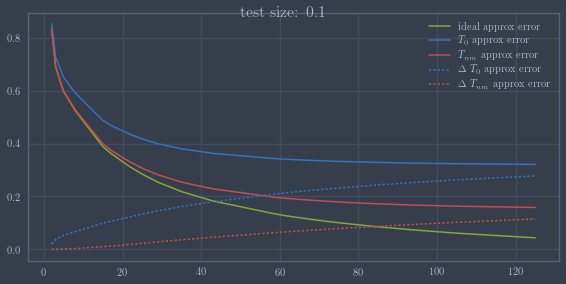

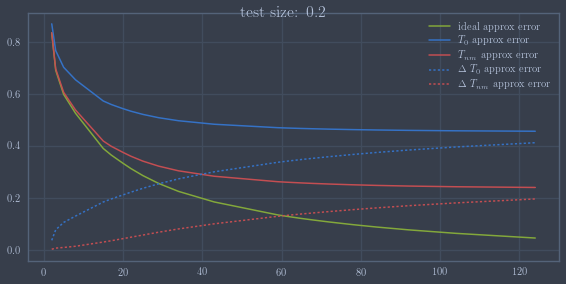

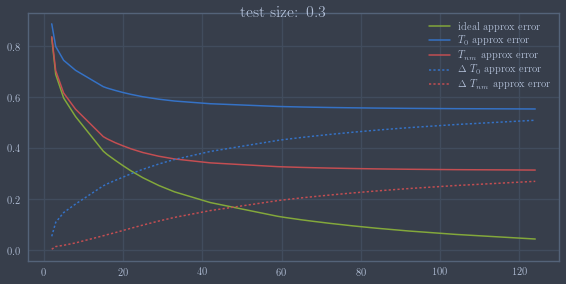

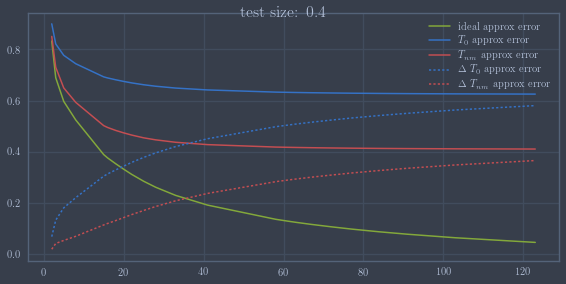

In [29]:
level = 3
points = [0]
for l in array(range(level))+1:
    start = points[-1]
    points += [start+i/10**l for i in range(1,10)]

for test_size in [.1, .2, .3, .4]:
    X0, X1, features0, features1 = train_test_split(X, features, test_size=test_size, 
                                                random_state=int(np.random.random()*1260))
    mean0 = sum(X0, axis=0)/len(X0)
    T0 = tensoring(X0-mean0, features0)
    Tm = tensoring(X0-mean0, features0)
    Tm = fill_gaps(Tm, features0, features1)
    S0,U0 = hosvd(T0)
    Sm,Um = hosvd(Tm)
    
    error0 = []
    error1 = []
    error2 = []
    error01 = []
    error02 = []
    n_comp = []
    Sn = [array([norm(flaxis(Sm,i)[j]) for j in range(shape(Sm)[i])]) for i in range(len(shape(Sm)))]
    for alpha in points:
        dim = [28,5,3,3]+[PCN['Kaiser'](sn, alpha) for sn in Sn[-2:]]
        n_comp += [sum(dim[-2:])]

        T0tr = trunc(S0, U0, dim)
        Tmtr = trunc(Sm, Um, dim)
        Ttr = trunc(S, U, dim)
        error0 += [norm(T-Ttr)/norm(T)]
        error1 += [norm(T-T0tr)/norm(T)]
        error2 += [norm(T-Tmtr)/norm(T)]
        error01 += [error1[-1]-error0[-1]]
        error02 += [error2[-1]-error0[-1]]
        
    figure()
    suptitle('test size: ' + str(test_size), fontsize=16)
    plot(n_comp, error0, label=r'ideal approx error', color='g')
    plot(n_comp, error1, label=r'$T_0$ approx error', color='b')
    plot(n_comp, error2, label=r'$T_{nm}$ approx error', color='r')
    plot(n_comp, error01, ':',label=r'$\Delta\ T_0$ approx error', color='b')
    plot(n_comp, error02, ':',label=r'$\Delta\ T_{nm}$ approx error', color='r')
    legend()
    show()

## Постановка задачи классификации

In [30]:
test_points = [9, 1, 2, 3]

Для простоты (это не повлияет на результат) будем принимать полный массив признаков, начислять баллы за угаданные, а финальный подсчёт осуществляется как

\begin{equation}\frac{sum-sum_{min}}{sum_{max}-sum_{min}},\end{equation}

где $sum$ – сумма баллов верных меток на объектах тестовой выборки у алгоритма, ${sum}_{min}$ и ${sum}_{max}$ – сумма баллов, если бы все недостающие признаки остались со значением -1 (автоматически неверные) и, соответственно, если бы все они были заполнены исходными (и очевидно проверочными) значениями.

In [31]:
sum_score = lambda pred, test, points: sum((array(pred) == test)*points)

# TensorFaces
##### http://web.cs.ucla.edu/~dt/papers/eccv02/eccv02.pdf 
##### http://web.cs.ucla.edu/~dt/papers/icpr02/icpr02.pdf

## Стратегия обучения

Шаг 1.1. Формируем тензор из имеющихся фотографий.

Шаг 1.2. Заполняем пропуски изложенным выше способом.

Шаг 1.3. Находим HOSVD. При необходимости, оставляем главные компоненты.

## Стратегия классификации
Шаг 2.1. Для заданного объекта оставляем подтензор, полученный фиксацией известных индексов.

Шаг 2.2. Обучаем t классификаторов (например линейную регрессию), если t признаков неизвестно.

Шаг 2.3. Прогнозируем признаки, переходим к следующему объекту и возвращаемся к шагу 2.1.

In [39]:
class TensorFaces(object):
    def reconstruct(self,features): 
        U = []
        for u,ftr in zip(self.U,features):
            U += [u[ftr:ftr+1]]
        U += self.U[len(features):]
        return gmul(self.S,U)[tuple(array(features)*0)]
    
    def __init__(self, X, features, alpha=0.95, vectorization=False):
        '''Class initialization
        
        Args:
            X[k,m,n]: set of k images m*n pixels each
            features[k,n1,...,nt]: t features of k images'''
        
        # 1-2. Tensoring + filling gaps
        features = array(features)
        n_features = len(features[0])
        set_features = [set(array(features)[:,i]) for i in range(n_features)]
        all_features = array(list(itertools.product(*set_features)))
        
        self.mean = sum(X, axis=0)/len(X)
        self.rank = tuple([max(f)+1 for f in set_features])+shape(X[0])
        tensor = zeros(self.rank)
        tensor = tensoring(X-self.mean, features)
        tensor = fill_gaps(tensor, features, all_features)
        
        # 3. HOSVD
        N = len(shape(tensor))
        A = [flat(tensor, k) for k in range(N)]
        self.U = [linalg.svd(A[k], full_matrices=False)[0] for k in range(N)]
        self.S = gmul(tensor, [transpose(u) for u in self.U])
        
        Sn = [array([norm(flaxis(self.S,i)[j]) for j in range(shape(self.S)[i])]) 
              for i in range(len(shape(self.S)))]
        self.dim = [28,5,3,3]+[PCN['Kaiser'](sn, alpha) for sn in Sn[-2:]]
        tensor,self.S,self.U = trunc(self.S,self.U,self.dim,su=True)
        
    def clf(self, X, features, test_points=[3,0,1,2]):
        preds = []
        y = copy.deepcopy(features)
        
        priority = list(reversed(argsort(test_points)))
        zeros = len([1 for tp in test_points if tp<=0])
        priority = priority[:len(priority)-zeros]

        for face,ftr in zip(X-self.mean,y):
            # 1. Выделяем подтензор 
            # (сокращаем поле поиска)
            U = []
            
            for feature,u in zip(ftr, self.U):
                if feature < 0:
                    U += [u]
                else:
                    U += [u[feature:feature+1]]
            subtensor = gmul(self.S, U)
            dm = self.dim[-len(shape(face)):]
            
            # 2. Обучаем классификаторы
            # (последовательность - по возрастанию очков)
            for p in reversed(priority):
                if ftr[p]<0:
                    # Подготовка обучающей выборки
                    train_size = int(product(shape(subtensor)[:-len(dm)]))
                    train_shape = [train_size,product(self.dim[-len(shape(face)):])]
                    X_train = reshape(subtensor, train_shape)
                    y_train = concatenate([[i]*int(train_size/self.dim[p]) for i in range(self.dim[p])])
                    
                    # Подготовка тестовой выборки
                    projection = gmul(face,[self.U[i-len(dm)].T for i in range(len(dm))])
                    x_test = reshape(projection,[product(shape(projection))]) 
                    
                    # 3. Классифицируем методом 3 ближайших соседей
                    #pred = y_train[argmin(sum((X_train-x_test)**2,axis=1))]
                    clf = KNeighborsClassifier(n_neighbors=1)
                    pred = clf.fit(X_train, y_train).predict([x_test])[0]
                    
                    ftr[p] = pred
            preds += [ftr]
        return preds

# Тестирование алгоритма

### Тест 1. Угадать от 1-го до 4-х отсутствующих признаков

In [113]:
test_points = [9, 1, 2, 3]

In [114]:
X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))

In [115]:
n = 300 # Размер тестовой выборки
k = 4 # Максимальное число отсутствующих признаков (минимум 1)

n = min(n,len(features1))
ftr_true = features1[:n]

ftr_test = copy.deepcopy(ftr_true)
for i in range(n): 
    for j in set(np.random.choice(range(4),np.random.choice(range(k))+1,replace=False)):
        ftr_test[i][j] = -1

In [116]:
TF = TensorFaces(X0, features0)

In [117]:
t0 = time.time()
predicts = TF.clf(X1[:n], ftr_test[:n], test_points)

print(time.time()-t0,'sec')

1.7685582637786865 sec


In [118]:
score_clf = sum_score(predicts, ftr_true, test_points)
score_min = sum_score(ftr_test, ftr_true, test_points)
score_max = sum_score(ftr_true, ftr_true, test_points)

result = (score_clf-score_min)/(score_max-score_min)
print(round(result,4)*100,'%')

66.67 %


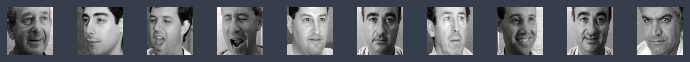

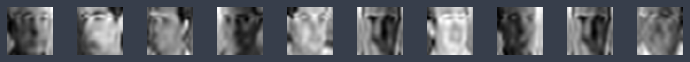

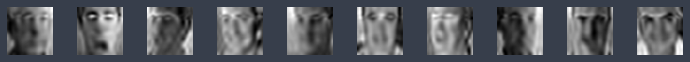

In [119]:
m = 10
show_tests = False

if show_tests:
    for t in zip(ftr_true[:m], ftr_test[:m], predicts[:m]):
        print(vectorize(lambda x: '*' if x<0 else str(x))(vstack(t)))
        print()

X2 = [TF.reconstruct(p) for p in ftr_true[:m]]
X3 = [TF.reconstruct(p) for p in predicts[:m]]

show_gallery(X1[:m],1,m) # Оригинал
show_gallery(X2,1,m) # Предполагаемая аппроксимация
show_gallery(X3,1,m) # Предсказанная аппроксимация

#### Тот же эксперимент повторим 10 раз

In [123]:
T = 10 # Число тестов
k = 4

result = 0
for t in range(T):
    X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))
    ftr_true = features1
    ftr_test = copy.deepcopy(ftr_true)
    for i in range(len(features1)): 
        for j in set(np.random.choice(range(4),np.random.choice(range(k))+1,replace=False)):
            ftr_test[i][j] = -1
    predicts = TensorFaces(X0, features0).clf(X1[:n], ftr_test[:n], test_points)

    score_clf = sum_score(predicts, ftr_true, test_points)
    score_min = sum_score(ftr_test, ftr_true, test_points)
    score_max = sum_score(ftr_true, ftr_true, test_points)
    result += (score_clf-score_min)/(score_max-score_min)
print(round(result/T,4)*100,'%')

67.62 %


### Тест 2. Угадать человека, до 3-х остальных признаков неизвестно

In [49]:
test_points = [1,0,0,0]

In [50]:
X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))

In [51]:
n = len(features1) # Размер тестовой выборки
k = 3 # Максимальное число отсутствующих признаков (минимум 1)

n = min(n,len(features1))
ftr_true = features1[:n]

ftr_test = copy.deepcopy(ftr_true)
for i in range(n): 
    ftr_test[i][0] = -1
    for j in set(np.random.choice(range(1,4),np.random.choice(range(k+1)),replace=False)):
        ftr_test[i][j] = -1

In [52]:
TF = TensorFaces(X0, features0)

In [53]:
t0 = time.time()
predicts = TF.clf(X1[:n], ftr_test[:n], test_points)

print(time.time()-t0,'sec')

1.010977029800415 sec


In [54]:
score_clf = sum_score(predicts, ftr_true, test_points)
score_min = sum_score(ftr_test, ftr_true, test_points)
score_max = sum_score(ftr_true, ftr_true, test_points)

result = (score_clf-score_min)/(score_max-score_min)
print(round(result,4)*100,'%')

88.89 %


#### Тот же эксперимент повторим 10 раз

In [124]:
T = 10 # Число тестов
test_points = [1,0,0,0]
k = 3

result = 0
for t in range(T):
    X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))
    ftr_true = features1
    ftr_test = copy.deepcopy(ftr_true)
    for i in range(len(features1)): 
        ftr_test[i][0] = -1
        for j in set(np.random.choice(range(1,4),np.random.choice(range(k+1)),replace=False)):
            ftr_test[i][j] = -1
    predicts = TensorFaces(X0, features0).clf(X1, ftr_test, test_points)

    score_clf = sum_score(predicts, ftr_true, test_points)
    score_min = sum_score(ftr_test, ftr_true, test_points)
    score_max = sum_score(ftr_true, ftr_true, test_points)
    result += (score_clf-score_min)/(score_max-score_min)
print(round(result/T,4)*100,'%')

87.62 %


### Тест 3. Угадать человека, остальные признаки известны

In [74]:
test_points = [1,0,0,0]

In [88]:
X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))

In [89]:
n = len(features1) # Размер тестовой выборки

n = min(n,len(features1))
ftr_true = features1[:n]

ftr_test = copy.deepcopy(ftr_true)
for i in range(n): 
    ftr_test[i][0] = -1

In [90]:
TF = TensorFaces(X0, features0)

In [91]:
t0 = time.time()
predicts = TF.clf(X1[:n], ftr_test[:n], test_points)

print(time.time()-t0,'sec')

0.526339054107666 sec


In [92]:
score_clf = sum_score(predicts, ftr_true, test_points)
score_min = sum_score(ftr_test, ftr_true, test_points)
score_max = sum_score(ftr_true, ftr_true, test_points)

result = (score_clf-score_min)/(score_max-score_min)
print(round(result,4)*100,'%')

89.68 %


#### Тот же эксперимент повторим 10 раз

In [125]:
T = 10 # Число тестов
test_points = [1,0,0,0]

result = 0
for t in range(T):
    X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))
    ftr_true = features1
    ftr_test = copy.deepcopy(ftr_true)
    for i in range(len(features1)): 
        ftr_test[i][0] = -1
    predicts = TensorFaces(X0, features0).clf(X1, ftr_test, test_points)

    score_clf = sum_score(predicts, ftr_true, test_points)
    score_min = sum_score(ftr_test, ftr_true, test_points)
    score_max = sum_score(ftr_true, ftr_true, test_points)
    result += (score_clf-score_min)/(score_max-score_min)
print(round(result/T,4)*100,'%')

86.07 %


### Тест 4. Угадать ракурс, известно только кто на фотографии

In [106]:
test_points = [0,1,0,0]

In [107]:
X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))

In [108]:
n = len(features1) # Размер тестовой выборки

n = min(n,len(features1))
ftr_true = features1[:n]

ftr_test = copy.deepcopy(ftr_true)
for i in range(n):
    for j in range(1,4):
        ftr_test[i][j] = -1

In [109]:
TF = TensorFaces(X0, features0)

In [110]:
t0 = time.time()
predicts = TF.clf(X1[:n], ftr_test[:n], test_points)

print(time.time()-t0,'sec')

0.3205759525299072 sec


In [111]:
score_clf = sum_score(predicts, ftr_true, test_points)
score_min = sum_score(ftr_test, ftr_true, test_points)
score_max = sum_score(ftr_true, ftr_true, test_points)

result = (score_clf-score_min)/(score_max-score_min)
print(round(result,4)*100,'%')

97.22 %


#### Тот же эксперимент повторим 10 раз

In [130]:
T = 10 # Число тестов
test_points = [0,1,0,0]

result = 0
for t in range(T):
    X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))
    ftr_true = features1
    ftr_test = copy.deepcopy(ftr_true)
    for i in range(len(features1)):
        for j in range(1,4):
            ftr_test[i][j] = -1
    predicts = TensorFaces(X0, features0).clf(X1, ftr_test, test_points)

    score_clf = sum_score(predicts, ftr_true, test_points)
    score_min = sum_score(ftr_test, ftr_true, test_points)
    score_max = sum_score(ftr_true, ftr_true, test_points)
    result += (score_clf-score_min)/(score_max-score_min)
print(round(result/T,4)*100,'%')

93.77 %


### Тест 5. Угадать освещение, остальные признаки известны

In [67]:
test_points = [0,0,1,0]

In [68]:
X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))

In [69]:
n = len(features1) # Размер тестовой выборки

n = min(n,len(features1))
ftr_true = features1[:n]

ftr_test = copy.deepcopy(ftr_true)
for i in range(n):
    ftr_test[i][2] = -1

In [70]:
TF = TensorFaces(X0, features0, alpha=0.7)

In [71]:
t0 = time.time()
predicts = TF.clf(X1[:n], ftr_test[:n], test_points)

print(time.time()-t0,'sec')

0.23864221572875977 sec


In [72]:
score_clf = sum_score(predicts, ftr_true, test_points)
score_min = sum_score(ftr_test, ftr_true, test_points)
score_max = sum_score(ftr_true, ftr_true, test_points)

result = (score_clf-score_min)/(score_max-score_min)
print(round(result,4)*100,'%')

98.81 %


#### Тот же эксперимент повторим 10 раз

In [129]:
T = 10 # Число тестов
test_points = [0,0,1,0]

result = 0
for t in range(T):
    X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))
    ftr_true = features1
    ftr_test = copy.deepcopy(ftr_true)
    for i in range(len(features1)):
        ftr_test[i][2] = -1
    predicts = TensorFaces(X0, features0).clf(X1, ftr_test, test_points)

    score_clf = sum_score(predicts, ftr_true, test_points)
    score_min = sum_score(ftr_test, ftr_true, test_points)
    score_max = sum_score(ftr_true, ftr_true, test_points)
    result += (score_clf-score_min)/(score_max-score_min)
print(round(result/T,4)*100,'%')

96.83 %
